# Using NER to "manually" debias sentences

In [111]:
# Import media bias dataset
import pandas as pd
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score



The dataset we are using can be found [here](https://github.com/Media-Bias-Group/Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE/tree/main/data) as "final_labels_sg1". It is a dataset containing news headlines which have been labelled manually as biased or non-biased, including any potential biased words. In this notebook we want to identify if a country or city is mentioned in the text, and if so, remove the corresponding biased words from the text. We can then compare the textual similarity between a debiased sentence and an originally non-biased sentence, where the sentiment is similar, to assess the debiasing.

In [61]:
url='https://docs.google.com/spreadsheets/d/1KKPAiOppopEzbnINsdl-OVR8WOg2ly1a/edit?usp=drive_link&ouid=109883226317661265367&rtpof=true&sd=true'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df = pd.read_excel(dwn_url)
df.head(3)


,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican presid...,http://www.msnbc.com/...,msnbc,environment,left,Biased,Expresses writer’s op...,[]
1,Though the indictment...,https://eu.usatoday.c...,usa-today,abortion,center,Non-biased,Somewhat factual but ...,[]
2,Ingraham began the ex...,https://www.breitbart...,breitbart,immigration,right,No agreement,No agreement,['flood']


We will use Named-Entity Recognition (NER) to identify whether the sentence contains a named city or country. These are pre-trained models designed to pick out names or entities within a text, for example cities or countries. It is possible to train your own NER model using spaCy to identify entities specific to your domain however here we will use one that is pre-trained to identify cities and countries, as these could be a potential source of bias depending on what city or country is mentioned. As for now, we are not looking at the specific city or country, rather just checking whether one is mentioned or not in the text.

In [62]:
tokenizer = AutoTokenizer.from_pretrained("ml6team/bert-base-uncased-city-country-ner")
model = AutoModelForTokenClassification.from_pretrained("ml6team/bert-base-uncased-city-country-ner")
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)

Applying the NER model to the text in the dataframe and adding a new column "ner" that contains the entities (if any)

In [63]:
df_places = pd.DataFrame(df['text'].apply(nlp))
df_places = df_places.rename(columns={'text':'ner'})

We now have a dataframe containing the text, whether or not a city or country appears in the text, whether or not the text is biased, and any potential biased words in the text

In [64]:
df_ner = pd.concat([df_places,df], axis=1)

Removing the biased words from the sentences, using the following logic: If the 'ner' and 'biased_words' columns are not empty, then remove the biased words from the corresponding text.

In [65]:
import ast
# Convert string representations of lists into actual lists
df_ner['ner'] = df_ner['ner'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_ner['biased_words'] = df_ner['biased_words'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [66]:
def remove_biased_words(row):
    text = row['text']
    
    # Initialize the filtered sentence with the original text
    filtered_sentence = text
    
    # Only proceed if both 'ner' and 'biased_words' are not empty
    if row['ner'] and row['biased_words']:
        biased_words = set(word.lower() for word in row['biased_words'])
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in biased_words]
        filtered_sentence = ' '.join(filtered_words)
    
    return filtered_sentence

# Apply the function to each row
df_ner['text'] = df_ner.apply(remove_biased_words, axis=1)

```df_main``` is a dataframe containing the original text in one column and the "debiased text" in another

In [67]:
df_ner = df_ner.rename(columns={'text':'debiased_text'})
df_main = pd.concat([df['text'], df_ner['debiased_text']], axis=1)

Importing Universal Sentence Encoder (USE) for similarity and sentiment analysis. USE is a deep learning model which encodes textual inputs into high-dimensional vector spaces, preserving any semantic information, i.e. sentences with similar semantic meaning will have similar embeddings. 

Our hypothesis is: suppose there are two sentences one being biased and one non-biased, with similar semtantic meanings (i.e. talking about similar subjects). After debiasing the biased sentence we should still expect a similar semantic meaning. If the semantic meaning changes it could be because the biased words are the contributing factor to the sentence sentiment. 

In [99]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


Attempting to pick out suitable sentences for comparison. We will filter by topic: immigration only as these are more likely to yield semantically similar sentences.

In [100]:
pd.options.display.max_colwidth = 25
# Filter dataframe to contain the 'immigration' topic only

df_immigration = df_ner[df_ner['topic']=='immigration']
df_immigration

,ner,debiased_text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
2,[],Ingraham began the ex...,https://www.breitbart...,breitbart,immigration,right,No agreement,No agreement,[flood]
6,[{'entity_group': 'CI...,After the airstrike t...,https://eu.usatoday.c...,usa-today,immigration,center,Non-biased,Entirely factual,[]
11,[{'entity_group': 'CI...,"Last week, Ankara bro...",https://www.breitbart...,breitbart,immigration,right,Biased,No agreement,[]
28,[],"In practical terms, T...",http://www.msnbc.com/...,msnbc,immigration,left,Biased,Somewhat factual but ...,"[dramatically, curtai..."
29,[{'entity_group': 'CO...,"Victorina Morales, an...",https://eu.usatoday.c...,usa-today,immigration,center,Non-biased,Entirely factual,[]
...,...,...,...,...,...,...,...,...,...
1618,[{'entity_group': 'CI...,"In October, Breitbart...",https://www.breitbart...,breitbart,immigration,right,Biased,Entirely factual,[allegedly]
1623,[{'entity_group': 'CI...,But as early as this ...,https://eu.usatoday.c...,usa-today,immigration,center,Non-biased,Entirely factual,[]
1645,[],The Trump Administrat...,https://www.alternet....,alternet,immigration,left,Biased,Somewhat factual but ...,"[claims, riling]"
1672,[],"Her plight, along wit...",https://eu.usatoday.c...,usa-today,immigration,center,Non-biased,Expresses writer’s op...,[]


In [101]:
sentence_1 = df_main['text'][29]
sentence_2 = df_main['text'][1618]
sentence_2d = df_main['debiased_text'][1618]

print(f'Non-biased sentence: {sentence_1}')
print(f'Biased Sentence: {sentence_2}')
print(f'Debiased Sentence {sentence_2d}')

Non-biased sentence: Victorina Morales, an undocumented immigrant from Guatemala, told reporters in a conference call on Tuesday that she was allowed to work at the resort after she submitted a fraudulent Social Security number and green card, which she alleges her supervisors knew were phony.
Biased Sentence: In October, Breitbart London reported that French police are allegedly actively assisting migrants to avoid detection by UK Border Force, telling them when and when not to attempt to cross the channel, according to a people smuggler.
Debiased Sentence In October, Breitbart London reported that French police are actively assisting migrants to avoid detection by UK Border Force, telling them when and when not to attempt to cross the channel, according to a people smuggler.


In [102]:
# Plotting functions
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(['Sentence 1', 'Sentence 2'], message_embeddings_, 90)

Textual similarity between ```sentence_1``` and ```sentence_2```

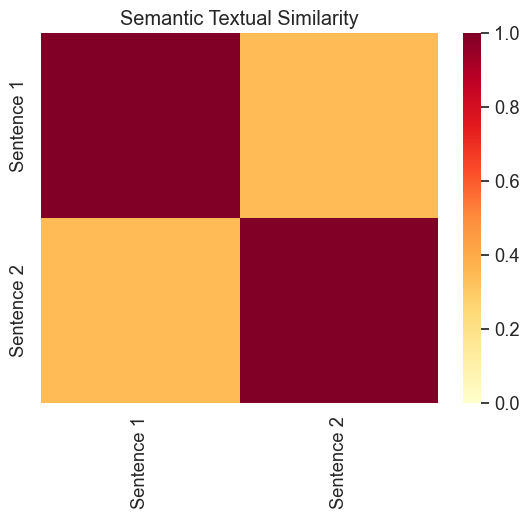

In [72]:
run_and_plot([sentence_1, sentence_2])

Textual similarity between ```sentence_1``` and ```sentence_2d```

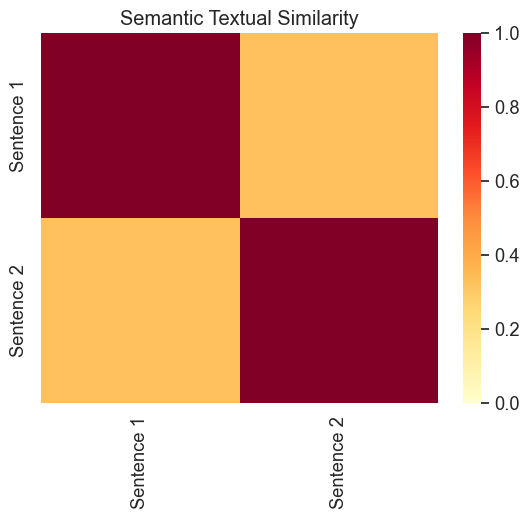

In [73]:
run_and_plot([sentence_1, sentence_2d])

# Testing debiasing using a classifier 

Now that we have a debiased dataset (based on removing the biased words from sentences contaning country and/or city names) we can train a classifier to predict the bias using the biased dataset and then testing whether prediction of a biased sentence changes to non-biased by feeding in the non-biased sentence into the model. 

Convert the text to sentence embeddings using USE

In [121]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)


text = df['text'].tolist()
debiased_text = df_ner['debiased_text'].tolist()
bias = df['label_bias']

# Embed text
text_embeddings = embed(text)
text_embeddings = text_embeddings.numpy()

# Embed debiased text
debiased_text_embeddings = embed(debiased_text)
debiased_text_embeddings = debiased_text_embeddings.numpy()

# Encode bias labels
le = LabelEncoder()
bias_encoded = le.fit_transform(bias)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


Train a classifier using the text as the input and the bias as the target output

In [131]:
models = {
    #"Logistic Regression": LogisticRegression(),
    #"Random Forest": RandomForestClassifier(),
    #"Gradient Boosting": GradientBoostingClassifier(),
    #"Neural Network": MLPClassifier(hidden_layer_sizes=(200,), max_iter=250),
    #"XGBoost": xgb.XGBClassifier(),
    "SVM": SVC(kernel='linear')
}

results = {}

for model_name, model in models.items():
    accuracies = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(text_embeddings, bias_encoded, test_size=0.1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
    average_accuracy = np.mean(accuracies)
    results[model_name] = average_accuracy

for model_name, avg_accuracy in results.items():
    print(f"{model_name}: Average Accuracy over 10 iterations: {avg_accuracy}")

SVM: Average Accuracy over 10 iterations: 0.6564705882352943


Identify a biased sentence from the dataset and it's corresponding debiased counterpart. If debiasing is successful using this method, we would expect the model output to be 0 when the first sentence is fed in and then 1 for the second. 

In [142]:
idx = 35
# An instance of a biased sentence 
x = text_embeddings[idx].reshape(1,-1)
# An intance of the same sentence with the bias words removed
x_d = debiased_text_embeddings[idx].reshape(1,-1)

0 = Biased,
1 = Non Biased,
2 = No agreement

It appears the output remains the same when the biased words are removed. This is somewhat expected, firstly, the model accuracy is only ~60% which is slightly better than guessing. The model may not even predict the bias correctly in the first place. Secondly, based on looking at the semantic meaning analysis above, we notice the semantic meaning between a biased and debiased sentence doesn't really change. Whilst this is something we want to a certain extent, this could indicate that removing a few words from the sentence isn't enough to change the semantic meaning enough to change the semantic bias. We want to preserve most if not all of the semantic meaning of the sentence, but change the sentence enough to remove the bias.

This is most likely due to the wide variety of semantic meanings between the sentences (this can be observed anecdotally just by reading some of the sentences in the dataset) along with lack of training data for the model.

This method could work better if we use an LLM or SLM to make the prediction and debias by using counterfactual generation instead of simply removing the biased words; the biased words in the dataset are manually labelled and could be subject to interpretation.

In [141]:
print(model.predict(x))
print(model.predict(x_d))



[2]
[2]
